# Project 2<br>Predict IMDb Rating

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import re
# Basic EDA, cleaning, and visualization modules

from bs4 import BeautifulSoup
from IPython.core.display import display, HTML
import requests
# Webscraping 

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import scipy.stats as stats
# Modeling

from directors_to_list import directors_list, remove_paren
from imdb_big_scrape import get_movie_links
from getting_info import get_movie_data
# Functions I made in corresponding .py files

import pickle
%load_ext autoreload
%autoreload 2

## Step 1: Collect links using the 'get_movie_links' function
This function gathers data from IMDb using BeautifulSoup. Specifically, the function focuses on movies between 2018 and 2020 to be accurate prediting in the near future. The input to the function is how many pages is desired to scrape. Each page holds 100 movies. The function is liable to take some time, so I like the option to scrape less pages if desired.

In [5]:
movie_links = get_movie_links(20)
# Collect movie links
# 5  -->  500 links
# 10 --> 1000 links
# 20 --> 2000 links
# 40 --> 4000 links

## Step 2: Use the 'get_movie_data' function to collect desired data
This function also uses BeautifulSoup and takes the links collected using the get_movie_links function to return a list full of dictionaries holding information for each link passed into the function. After collecting the data, it's very easy to pass this into a Pandas DataFrame.

In [10]:
count = 0
movie_data_list = []
for link in movie_links:
    movie_data_list.append(get_movie_data(link))
    count += 1
    if count % 50 == 0:
        with open('IMDb_top_2000s.pickle', 'wb') as to_write:
            pickle.dump(movie_data_list, to_write)
# Create list with all movies from movie links

In [184]:
df2 = pd.DataFrame(movie_data_list)

In [237]:
movie_page_info = pd.DataFrame(movie_data_list)
# Turn data into a DataFrame for easy analysis

In [3]:
movies_8000 = pd.DataFrame(pd.read_pickle('IMDb_8000.pickle'))
df1 = pd.DataFrame(pd.read_pickle('IMDb_top_movies.pickle'))
df2 = pd.DataFrame(pd.read_pickle('IMDb_top_2000s.pickle'))
# Reloaded pickled data after I reset the notebook
# IMDB_8000 contains 8000 movies between 2015 and 2020
# IMDb_top_movies supplements the data with top rated movies between 2010 and 2020
# IMDB_top_2000s supplements more top movies in the 2000s

In [4]:
movies_8070 = pd.concat([movies_8000,df1,df2])

## Step 3: Dive into the data to further understand relationships

In [5]:
movies_df = movies_8070.copy()
movies_df.drop_duplicates(subset=['movie title'],inplace=True)
# Copy the original dataframe to mess with the data more freely

In [6]:
movies_df.set_index('movie title',inplace=True)
# Reset the index to be the Movie Title

In [7]:
movies_df_drop = movies_df.dropna(subset=['budget'])
# Drop movies without budget data

In [8]:
movies_df_drop.info()
# See what we're working with

<class 'pandas.core.frame.DataFrame'>
Index: 2655 entries, Mulan to Cinderella Man
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb rating           2495 non-null   float64
 1   imdb raters           2495 non-null   float64
 2   mpaa                  1581 non-null   object 
 3   genres                2654 non-null   object 
 4   director              2652 non-null   object 
 5   writer                2651 non-null   object 
 6   stars                 2594 non-null   object 
 7   country               2655 non-null   object 
 8   language              2655 non-null   object 
 9   release date          2464 non-null   object 
 10  budget                2655 non-null   float64
 11  opening weekend       931 non-null    float64
 12  gross usa             957 non-null    float64
 13  cumulative worldwide  1118 non-null   float64
 14  production companies  2480 non-null   object 
 15  runtime (min

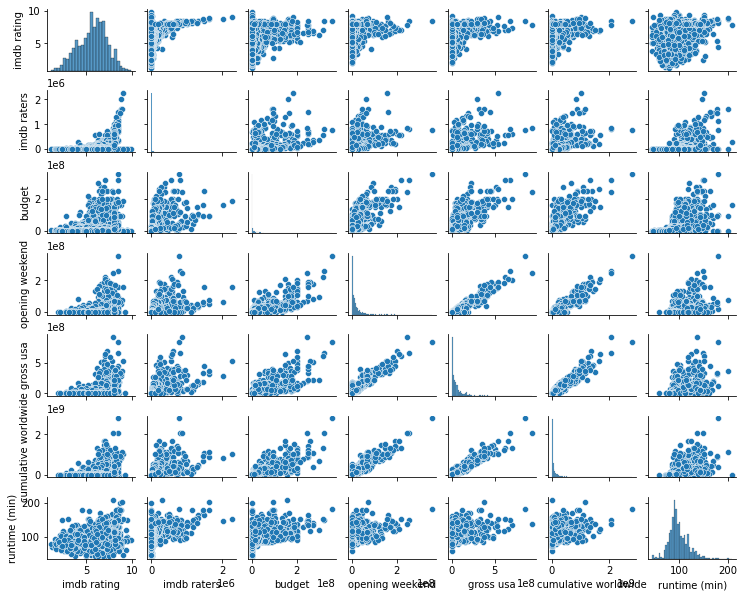

In [9]:
sns.pairplot(movies_df_drop, height=1.2, aspect=1.25);
# Visualize some relationships

## Step 4: Clean up data and add features

Drop rows with no rating, no release date, and no runtime<br>
Fill rows with empy MPAA with the filler 'N/A'

In [10]:
movies_df_drop['mpaa'].fillna('N/A', inplace=True)
# I don't want to lose titles with no MPAA, so let's fill in missing values with "N/A"

In [11]:
movie_drop2 = movies_df_drop[movies_df_drop['imdb rating'].notna()]
# Drop movies without a rating

In [12]:
movie_drop2 = movie_drop2[movie_drop2['imdb raters'] >= 1000]
# Remove movies with less than 1,000 raters for better validity in ratings

In [13]:
movie_drop2 = movie_drop2[movie_drop2['budget'] >= 1000]
# Remove movies with less than a $1,000 budget to focus model

In [14]:
movie_drop2 = movie_drop2[movie_drop2['runtime (min)'].notna()]
# Removes movies without Runtime data

### Feature: Runtime
Test out a basic component of the new DataFrame.<br>
Target: IMDb Rating

In [15]:
X, y = movie_drop2[['runtime (min)']], movie_drop2['imdb rating']

In [16]:
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)

0.26865461610593155

Turned out small, but I think we can do better.<br>
Let's attempt to turn MPAA into dummy variables

### Feature: MPAA Rating

In [17]:
mpaa_df = pd.get_dummies(movie_drop2['mpaa'])
# Get dummy variables for MPAA ratings

In [18]:
df_added_mpaa_dummies = pd.concat([movie_drop2,mpaa_df], axis=1)
# Add them to the rest of the data

In [19]:
X, y = df_added_mpaa_dummies[['runtime (min)','budget','G','N/A','Not Rated','PG','PG-13','R','TV-MA','Unrated']], df_added_mpaa_dummies['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)
# Let's add the MPAA dummy variables and budget to our model

0.31809837437427413

The result was only a little bit better with the MPAA data. <br>
Let's try to add in genre dummy variables


### Feature: Genre

In [20]:
df_genres_added = pd.Series(df_added_mpaa_dummies['genres'])
df_genres_added = pd.get_dummies(df_genres_added.apply(pd.Series).stack()).sum(level=0)
# Turns genres into dummy variables

In [21]:
df_genres_mpaa = pd.concat([df_added_mpaa_dummies, df_genres_added], axis=1)

In [22]:
df_genres_mpaa.drop(labels=['opening weekend','gross usa','cumulative worldwide'],axis=1,inplace=True)
# Let's drop the columns we're not using to make it easier to view

In [23]:
X, y = df_genres_mpaa[['runtime (min)','budget','G','N/A','Not Rated','PG','PG-13','R','TV-MA','Unrated','Action','Adventure','Animation','Biography','Comedy','Crime','Drama','Family','Fantasy','History','Horror','Music','Musical','Mystery','Romance','Sci-Fi','Sport','Thriller','War','Western']], df_genres_mpaa['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)

0.3996964906277858

Simple initial tests worked fairly well to get an MVP.<br>
Now I'd like to try and sort out Director, Writer, and Stars columns to create<br>
some more intricate measures of success

### Feature: Director

In [24]:
movie_drop2[movie_drop2['director']==''].index.tolist()

['Spider-Man: Into the Spider-Verse',
 'Moana',
 'Zootopia',
 'Despicable Me 3',
 'Animal Crackers',
 'The Lego Ninjago Movie',
 'The Wild Life',
 'The Heyday of the Insensitive Bastards',
 'Dude Bro Party Massacre III',
 'Sin City',
 'Monsters, Inc.']

It seems like there are a few movings missing their director information. I'll just add in this information manually since it's only a few.

In [25]:
empty_dir = movie_drop2[movie_drop2['director']==''].index.values.tolist()
# Putting those movies into a list

In [26]:
dir_fill = [
    'Peter Ramsey, Bob Persichetti, Rodney Rothman',
    'Ron Clements, John Musker',
    'Byron Howard, Rich Moore',
    'Pierre Coffin, Chris Renaud',
    'Scott Sava, Tony Bancroft',
    'Charlie Bean, Bob Logan, Paul Fisher',
    'Vincent Kesteloot, Ben Stassen',
    'Mark Columbus, Shadae Lamar Smith',
    'Michael Rousselet, Jon Salmon',
    'Frank Miller, Quentin Tarantino, Robert Rodriguez',
    'Dan Scanlon, Saschka Unseld'
    ]
# Got the directors corresponding to the movies

In [27]:
for num, movie in enumerate(empty_dir):
    movie_drop2['director'][movie] = dir_fill[num]
# Run through the empty directors and fill with added info

In [28]:
movie_drop2['director'] = movie_drop2['director'].apply(lambda x: directors_list(x))
# Turns directors into a list to fix some inconsistencies

In [29]:
movie_drop2['director'] = movie_drop2['director'].apply(lambda x: remove_paren(x))
# Remove parentheses in director columns

In [30]:
df_dir_exploded = movie_drop2.explode('director')
# Explode out directors to report on their relevance

In [31]:
dir_10 = df_dir_exploded['director'].value_counts()[:10].index.tolist()

In [32]:
def top_directors(directors):
    dir_list = []
    for director in directors:
        if director in dir_10:
            dir_list.append(director)
    return dir_list
# Create a function to select top directors and create new columns
# This will let us create dummy variables just for top directors

In [33]:
movie_drop2['top directors'] = movie_drop2['director'].apply(lambda x: top_directors(x))

In [34]:
dir_df = pd.get_dummies(movie_drop2['top directors'].apply(pd.Series).stack()).sum(level=0)

In [35]:
df_dir_model = pd.concat([df_genres_mpaa, dir_df], axis=1)

In [36]:
df_dir_model.drop(labels=['imdb raters','genres','director','writer','stars','country','language','release date','production companies'],axis=1,inplace=True)
# Let's take out the columns we're not using

In [37]:
df_dir_model.replace(np.nan,0,inplace=True)
# Replace all of the NaN values with 0s to turn it into a proper binary dataset

In [38]:
X, y = df_dir_model.iloc[:,2:], df_dir_model['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)
# So we moved up 0.02 points again, which isn't nothing. Let's try the same concept for writers

0.4295053158496933

So this model was only a small improvement, but let's keep adding features

### Feature: Writer

In [39]:
writ_df = pd.get_dummies(movie_drop2['writer'])
# The writer column isn't in list form, so we can just get dummy variables

In [40]:
writ_10 = movie_drop2.writer.value_counts()[:10].index.tolist()
# Let's only single out the top 10 most frequently occuring writers

In [41]:
df_writ_model = pd.concat([df_dir_model,writ_df[writ_10]],axis=1)

In [42]:
X, y = df_writ_model.iloc[:,2:], df_writ_model['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)

0.4391621375755921

So we moved up a little over 0.01 points, which isn't nothing, either. Let's try the same concept for stars

### Feature: Stars

In [43]:
stars_exploded = movie_drop2.explode('stars')
# Let's do something similar to director

In [44]:
stars_20 = stars_exploded['stars'].value_counts()[:20].index.tolist()
# Let's take the top 20 stars instead of just 10

In [45]:
def top_stars(stars):
    star_list = []
    for star in stars:
        if star in stars_20:
            star_list.append(star)
    return star_list
# Create a function to select top stars and create new columns
# This will let us create dummy variables just for top stars

In [46]:
movie_drop2['top stars'] = movie_drop2['stars'].apply(lambda x: top_stars(x))

In [47]:
stars_df = pd.get_dummies(movie_drop2['top stars'].apply(pd.Series).stack()).sum(level=0)

In [48]:
star_model = pd.concat([df_writ_model, stars_df[stars_20]], axis=1)

In [49]:
star_model.replace(np.nan,0,inplace=True)

In [50]:
X, y = star_model.iloc[:,2:], star_model['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)

0.44800833770416537

Once again, this is the smallest improvement in our model. What else can we try?<br>
Let's try this same concept for Production Companies and then move on to a new approach.

### Feature: Production Company

In [51]:
prod_exploded = movie_drop2.explode('production companies')
# You know the drill

In [52]:
prod_15 = prod_exploded['production companies'].value_counts()[:15].index.tolist()

In [53]:
movie_drop2.loc[movie_drop2['production companies'].isnull(),'production companies'] = movie_drop2.loc[movie_drop2['production companies'].isnull(),'production companies'].apply(lambda x: [])

In [54]:
def top_prod(comp):
    comp_list = []
    for co in comp:
        if co in prod_15:
            comp_list.append(co)
    return comp_list

In [55]:
movie_drop2['top prod co.'] = movie_drop2['production companies'].apply(lambda x: top_prod(x))

In [56]:
prod_df = pd.get_dummies(movie_drop2['top prod co.'].apply(pd.Series).stack()).sum(level=0)

In [57]:
prod_model = pd.concat([star_model, prod_df[prod_15]], axis=1)

In [58]:
prod_model.replace(np.nan,0,inplace=True)

In [59]:
X, y = prod_model.iloc[:,2:], prod_model['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)

0.4585210557057068

Once again, it's a very small increase.<br>
This was our last categorical column. I think it's worth trying the release month as a feature.

### Feature: Release Month

In [60]:
empty_date = movie_drop2[movie_drop2['release date'].isnull()].index.tolist()
# I noticed some movies without release dates
# Time to manually enter values

In [61]:
empty_date

['The Crash',
 'Burn Your Maps',
 '2020',
 'Cyborg X',
 'The Capture',
 'Bleed',
 'Bad Hero']

In [62]:
dates_fill = [
    pd.to_datetime('20170113', format='%Y%m%d'),
    pd.to_datetime('20160909', format='%Y%m%d'),
    pd.to_datetime('20170902', format='%Y%m%d'),
    pd.to_datetime('20160512', format='%Y%m%d'),
    pd.to_datetime('20171116', format='%Y%m%d'),
    pd.to_datetime('20160325', format='%Y%m%d'),
    pd.to_datetime('20101215', format='%Y%m%d')
    ]
# Got the release dates corresponding to the movies

In [63]:
for num, movie in enumerate(empty_date):
    movie_drop2['release date'][movie] = dates_fill[num]
# Run through the empty dates and fill with added info

In [64]:
movie_drop2['month'] = movie_drop2['release date'].apply(lambda x: x.strftime("%b"))
# Create new month column and fill in with month name

In [65]:
month_df = pd.get_dummies(movie_drop2['month'])
# Get dummies for the months

In [66]:
month_model = pd.concat([prod_model,month_df], axis=1)

In [67]:
X, y = month_model.iloc[:,2:], month_model['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)

0.4656299488474006

Once again, only slightly better than previous models.<br>
I'd like to add the years since release. I'm not entirely sure if it will correlate to IMDb rating, but it's worth a shot.

### Feature: Years since release

In [68]:
date = pd.to_datetime(datetime.now().date())

In [69]:
movie_drop2['years since release'] = movie_drop2['release date'].apply(lambda x: (((date-pd.to_datetime(x))).days/ 365.25))

In [70]:
month_model['years since release'] = movie_drop2['years since release']

In [71]:
X, y = month_model.iloc[:,2:], month_model['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)
# A little bit of a bump!

0.47851407789369116

## Step 5: Train / Validation / Test
Now that I've added all of the features I think are necessary, let's do some more intricate testing.

In [72]:
X, y = month_model.iloc[:,2:], month_model['imdb rating']
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=20)

In [73]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=20)

In [74]:
# Let's first test Linear Regression vs Polynomial Features
lr = LinearRegression()

poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lr_poly = LinearRegression()

In [75]:
lr.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lr.score(X_val, y_val):.3f}')

lr_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lr_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.367
Degree 2 polynomial regression val R^2: -7.321


The Degree 2 polynomial regression does not seem as good as Linear Regression; however, let's do some more rigorous testing on our basic Linear Regression model and try out a Ridge model

In [76]:
X, y = month_model.iloc[:,2:], month_model['imdb rating']

In [77]:
# Let's reset the data for the next tests
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)
X, y = np.array(X), np.array(y) # --> Might not be necessary
lr = LinearRegression()

In [78]:
# Here we'll validate our Linear model vs. the Ridge model
kf = KFold(n_splits=5, shuffle=True, random_state = 61)
cv_lr_r2s, cv_lr_reg_r2s = [], []

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #Linear Regression
    lr = LinearRegression()
    lr_reg = Ridge(alpha=1)

    lr.fit(X_train, y_train)
    cv_lr_r2s.append(lr.score(X_val, y_val))
    
    #Ridge
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lr_reg.fit(X_train_scaled, y_train)
    cv_lr_reg_r2s.append(lr_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lr_r2s)
print('Ridge scores: ', cv_lr_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lr_r2s):.3f} +- {np.std(cv_lr_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lr_reg_r2s):.3f} +- {np.std(cv_lr_reg_r2s):.3f}')

Simple regression scores:  [0.3818005673754402, 0.3073130166234428, 0.42654983510321043, 0.42704210056062963, 0.34894238997744376]
Ridge scores:  [0.3823553511463067, 0.3077798482664277, 0.42656167727845506, 0.4272409522391293, 0.34939614890222626] 

Simple mean cv r^2: 0.378 +- 0.046
Ridge mean cv r^2: 0.379 +- 0.046


It looks like the ridge model is performing slightly better than the simple Linear Regression model<br>
Let's investigate the data and model a bit more

In [79]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
# Rescale the data for more Ridge testing

In [80]:
lr_reg.fit(X_train_scaled, y_train)
cv_lr_reg_r2s.append(lr_reg.score(X_val_scaled, y_val))
# The code for our Ridge model

In [81]:
test_set_pred = lr_reg.predict(X_test_scaled)
# Set our predicted values to a variable

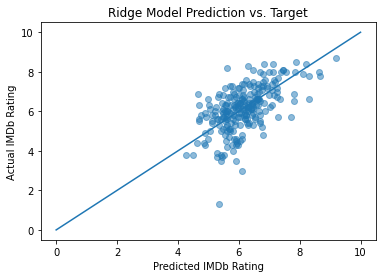

In [82]:
plt.scatter(test_set_pred, y_test, alpha=.5)
plt.plot(np.linspace(0,10), np.linspace(0,10))
plt.title('Ridge Model Prediction vs. Target')
plt.xlabel('Predicted IMDb Rating')
plt.ylabel('Actual IMDb Rating');
# The plot looks fairly decent

In [83]:
print(f'Ridge r2: {r2_score(y_test, test_set_pred)}')
# Also, this r2 score doesn't look too bad either

Ridge r2: 0.33015990604624423


In [84]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

print(f'MAE: {mae(y_test, test_set_pred)}')
# And a MAE of 0.67 isn't the worst

MAE: 0.726846629543588


In [368]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))

    pred = x

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot");

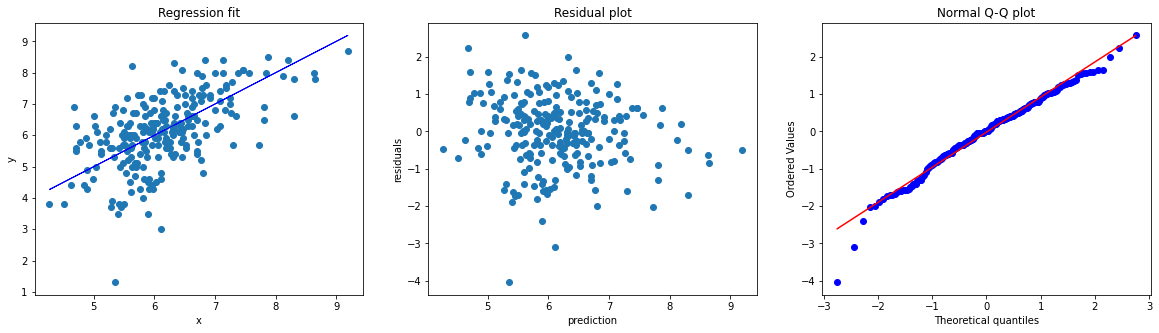

In [86]:
diagnostic_plot(test_set_pred, y_test)
# The head and tails of the Q-Q plot seem to tell a story about our data.
# Also, there seems to be an outlier than may be messing up our model, shown in the Regression fit.

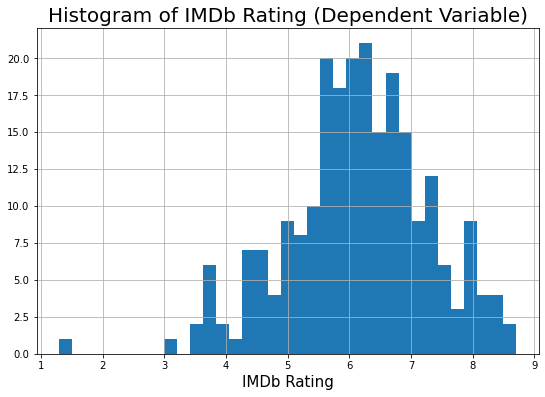

In [87]:
y_test.hist(bins=35,figsize=(9,6))
plt.title('Histogram of IMDb Rating (Dependent Variable)',fontsize=20)
plt.xlabel('IMDb Rating',fontsize=15);
# The histogram shows that our data is concentrated and there is one outlier in the lower range

## Step 6: Honing in on the important features<br>
Now that we have a decent model, let's use the insights from above to make it better.

In [88]:
X, y = month_model.iloc[:,2:], month_model['imdb rating']

In [89]:
X_scaled = scaler.fit_transform(X)
X_predicted = lr_reg.predict(X_scaled)
# Rescale the data for more Ridge testing

In [90]:
month_model['res'] = X_predicted - month_model['imdb rating']

In [91]:
month_model['res'].sort_values().head(20)
# The values are moving very slowly up to An Hour To Kill which has a large jump from BROS. Last Call.
# It seems like the bottom 5 are underpredicted

movie title
As I Am                             -3.871104
Love Struck Sick                    -3.487716
The Transcendents                   -3.311064
Love in Kilnerry                    -2.859478
An Hour to Kill                     -2.571565
BROS. Last Call                     -2.345017
The Grand Budapest Hotel            -2.276631
Never Hike Alone                    -2.191690
Paddington 2                        -2.172401
Bros.                               -2.158222
A Quiet Place                       -2.046038
Green Room                          -2.016478
Get Out                             -1.973293
1917                                -1.973200
Hardcore Henry                      -1.971733
Don't Breathe                       -1.951806
Joker                               -1.903664
Spider-Man: Into the Spider-Verse   -1.870615
Bilal: A New Breed of Hero          -1.733633
Upgrade                             -1.725947
Name: res, dtype: float64

In [92]:
underpredicted = month_model['res'].sort_values().head(5).index.tolist()

In [93]:
month_model['res'].sort_values().tail(20)
# This side is fairly similar, the numbers move pretty slowly up until Norm of the North
# It looks like the top 7 are underprediected

movie title
Slender Man              2.079367
Sextuplets               2.106238
God's Not Dead 2         2.107419
Black Christmas          2.112501
Sniper Special Ops       2.120947
Fifty Shades of Black    2.135733
The Asian Connection     2.139432
Battle for Skyark        2.211705
Holmes & Watson          2.235941
Jem and the Holograms    2.313904
The Perfect Weapon       2.329384
Bound                    2.408266
2307: Winter's Dream     2.490261
Norm of the North        2.740273
Fifty Shades of Grey     2.771604
The Emoji Movie          3.012461
#Horror                  3.114818
Verotika                 3.485675
Cats                     3.920062
Shark Exorcist           4.094342
Name: res, dtype: float64

In [94]:
overpredicted = month_model['res'].sort_values().tail(7).index.tolist()

In [163]:
movie_drop2.loc[underpredicted].index.tolist()

['As I Am',
 'Love Struck Sick',
 'The Transcendents',
 'Love in Kilnerry',
 'An Hour to Kill']

In [165]:
movie_drop2.loc[overpredicted].index.tolist()

['Norm of the North',
 'Fifty Shades of Grey',
 'The Emoji Movie',
 '#Horror',
 'Verotika',
 'Cats',
 'Shark Exorcist']

In [98]:
movie_drop2[movie_drop2['imdb raters'] < 1500].count()

imdb rating             65
imdb raters             65
mpaa                    65
genres                  65
director                65
writer                  65
stars                   65
country                 65
language                65
release date            65
budget                  65
opening weekend         10
gross usa               11
cumulative worldwide    26
production companies    65
runtime (min)           65
top directors           65
top stars               65
top prod co.            65
month                   65
years since release     65
dtype: int64

All of our underpredicted movies have a small number of individuals who rated those movies. This is something I accounted for going into the project, but I negated under 1,000 raters, so I will change that marker up to 1,500 raters. This removes 65 movies from our model, but that is only 5% of our data, so I think it is a good sacrifice. As for the overpredicted movies, there are a few movies that stand out: Cats and The Emoji Movie. Both of these films had big studios, well-known stars, and a lot of publicity, but were terrible concepts that the public did not receive well. As for Fifty Shades of Grey, it had a lot of promise and a lot of popularity, but it was a polarizing movie in the public's eye.

In [99]:
res_model = month_model[movie_drop2['imdb raters'] > 1500]

In [158]:
res_model.head(3)

imdb rating   mpaa       budget  runtime (min)  G  N/A  \
movie title                                                                   
Mulan                        5.4  PG-13  200000000.0          115.0  0    0   
The Invisible Man            7.1      R    7000000.0          124.0  0    0   
On the Basis of Sex          7.1  PG-13   20000000.0          120.0  0    0   

                     Not Rated  PG  PG-13  R  ...  Feb  Jan  Jul  Jun  Mar  \
movie title                                   ...                            
Mulan                        0   0      1  0  ...    0    0    0    0    0   
The Invisible Man            0   0      0  1  ...    1    0    0    0    0   
On the Basis of Sex          0   0      1  0  ...    0    1    0    0    0   

                     May  Nov  Oct  Sep  years since release  
movie title                                                   
Mulan                  0    0    0    1             0.093087  
The Invisible Man      0    0    0    0             0.610541  
On the Basis of Sex    0    0    0    0             1.741273  

[3 rows x 100 columns]

In [118]:
res_model.drop(labels='res',axis=1,inplace=True)
# Take out that residuals column

In [119]:
# Let's reset the data for the next tests
X, y = res_model.iloc[:,2:], res_model['imdb rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [120]:
# Scale the data to put into the model
X_tr_scaled = scaler.fit_transform(X_train)
X_te_scaled = scaler.fit_transform(X_test)

In [121]:
# Test our model with some folds
ridge_m = Ridge()
kf = KFold(n_splits=5, shuffle=True, random_state = 71)

In [122]:
# Fairly similar r2 to previous runs
cross_val_score(ridge_m, X_tr_scaled, y_train, cv=kf, scoring='r2')

array([0.34042826, 0.36454518, 0.38070041, 0.45900262, 0.4970072 ])

In [126]:
ridge_m.fit(X_tr_scaled,y_train)
ridge_m.score(X_te_scaled, y_test)

0.4066448126376073

This looks pretty good, but let's hone in on the right alpha value for ridge

In [128]:
# Using RidgeCV, we can see which alpha works best
m_alpha = RidgeCV(alphas=[0.1, 1.0, 10.0])
model_cv = m_alpha.fit(X_tr_scaled, y_train)
model_cv.alpha_

10.0

In [132]:
# I think we should look at alphas closer to 10 for further confirmation
m_alpha = RidgeCV(alphas=[8.0, 8.5, 9.0, 9.5, 10.0])
model_cv = m_alpha.fit(X_tr_scaled, y_train)
model_cv.alpha_

10.0

In [133]:
# It looks like 10 is the best bet!
ridge_m = Ridge(alpha=10)
ridge_m.fit(X_tr_scaled,y_train)
ridge_m.score(X_te_scaled, y_test)

0.40871776705817053

In [168]:
model_pred = ridge_m.predict(X_te_scaled)

In [360]:
print(mae(model_pred, y_test))

0.6544144113683573


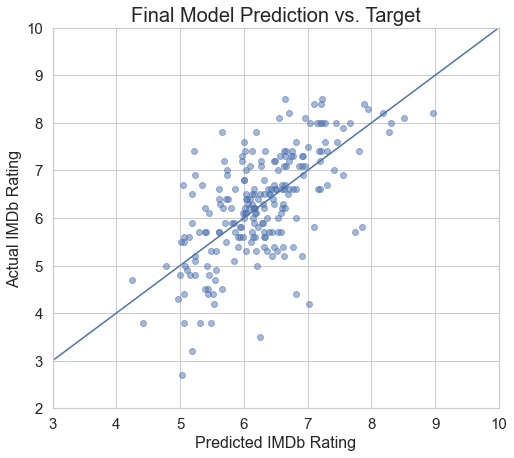

In [345]:
plt.scatter(model_pred, y_test, alpha=.5)
plt.plot(np.linspace(0,20), np.linspace(0,20))
plt.title('Final Model Prediction vs. Target',fontdict = {'fontsize' : 20})
plt.xlabel('Predicted IMDb Rating',fontdict = {'fontsize' : 16})
plt.ylabel('Actual IMDb Rating',fontdict = {'fontsize' : 16})
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([3,10,2,10])
# plt.savefig('final_model_line.png');

In [181]:
res_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1107 entries, Mulan to Cinderella Man
Data columns (total 100 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   imdb rating                1107 non-null   float64
 1   mpaa                       1107 non-null   object 
 2   budget                     1107 non-null   float64
 3   runtime (min)              1107 non-null   float64
 4   G                          1107 non-null   uint8  
 5   N/A                        1107 non-null   uint8  
 6   Not Rated                  1107 non-null   uint8  
 7   PG                         1107 non-null   uint8  
 8   PG-13                      1107 non-null   uint8  
 9   R                          1107 non-null   uint8  
 10  TV-MA                      1107 non-null   uint8  
 11  Unrated                    1107 non-null   uint8  
 12  Action                     1107 non-null   uint8  
 13  Adventure                  1107 non-nu

In [329]:
res_model['runtime (min)'].describe()

count    1107.000000
mean      108.677507
std        18.424860
min        54.000000
25%        95.000000
50%       106.000000
75%       119.000000
max       209.000000
Name: runtime (min), dtype: float64

In [355]:
movie_drop2[movie_drop2.writer == 'Christopher Nolan']

imdb rating  imdb raters   mpaa  \
movie title                                    
Dunkirk              7.9     536667.0  PG-13   
Inception            8.8    2017635.0  PG-13   
Memento              8.4    1105221.0      R   

                                              genres             director  \
movie title                                                                 
Dunkirk      [Action, Drama, History, Thriller, War]  [Christopher Nolan]   
Inception      [Action, Adventure, Sci-Fi, Thriller]  [Christopher Nolan]   
Memento                          [Mystery, Thriller]  [Christopher Nolan]   

                        writer  \
movie title                      
Dunkirk      Christopher Nolan   
Inception    Christopher Nolan   
Memento      Christopher Nolan   

                                                         stars country  \
movie title                                                              
Dunkirk         [Fionn Whitehead, Barry Keoghan, Mark Rylance]      UK   
Inception    [Leonardo DiCaprio, Joseph Gordon-Levitt, Elle...     USA   
Memento         [Guy Pearce, Carrie-Anne Moss, Joe Pantoliano]     USA   

            language release date  ...  opening weekend    gross usa  \
movie title                        ...                                 
Dunkirk      English   2017-07-21  ...       50513488.0  189740665.0   
Inception    English   2010-07-16  ...       62785337.0  292576195.0   
Memento      English   2001-05-25  ...         235488.0   25544867.0   

             cumulative worldwide  \
movie title                         
Dunkirk               526949403.0   
Inception             836836967.0   
Memento                39970386.0   

                                          production companies runtime (min)  \
movie title                                                                    
Dunkirk      [Syncopy, Warner Bros., Dombey Street Producti...         106.0   
Inception     [Warner Bros., Legendary Entertainment, Syncopy]         148.0   
Memento      [Newmarket Capital Group, Team Todd, I Remembe...         113.0   

                   top directors            top stars  \
movie title                                             
Dunkirk      [Christopher Nolan]                   []   
Inception    [Christopher Nolan]  [Leonardo DiCaprio]   
Memento      [Christopher Nolan]                   []   

                                        top prod co. month years since release  
movie title                                                                     
Dunkirk                               [Warner Bros.]   Jul            3.216975  
Inception    [Warner Bros., Legendary Entertainment]   Jul           10.231348  
Memento                                           []   May           19.373032  

[3 rows x 21 columns]

In [361]:
sorted_coef2 = sorted(coef_zip, key = lambda x: x[1])

In [362]:
sorted_coef2

[('Horror', -0.09422957036770149),
 ('Family', -0.08371263102007327),
 ('James Franco', -0.07201531520357002),
 ('Perfect World Pictures', -0.06817916265087498),
 ('Timothy Woodward Jr.', -0.0669942715038105),
 ('Thriller', -0.06114345345022055),
 ('Tyler Perry', -0.05964910504324664),
 ('Tyler Perry', -0.059649105043246615),
 ('Not Rated', -0.056820452446347806),
 ('Action', -0.048739772197667966),
 ('Jonathan Nolan', -0.048651457521320156),
 ('Adventure', -0.04522481474432166),
 ('TV-MA', -0.0451090115622932),
 ('Nicolas Cage', -0.04413016453327038),
 ('Martin Scorsese', -0.04233004414648149),
 ('May', -0.040288295253571034),
 ('Quentin Tarantino', -0.04006001476220921),
 ('Apr', -0.039625833912132875),
 ('Steven C. Miller', -0.037805074357520854),
 ('New Regency Productions', -0.03281440272639513),
 ('Jan', -0.029623074907177527),
 ('Twentieth Century Fox', -0.028066880190145173),
 ('Universal Pictures', -0.027469393535868847),
 ('Sep', -0.025254805068805883),
 ('PG-13', -0.02420111

You can tell that the data is more concetrated with the removal of movies with under 1,500 raters on IMDb. Also, I think it is able to predict the data fairly well. Let's see what features are the most important

In [156]:
coef_zip = list(zip(res_model.iloc[:,2:].columns.tolist(), ridge_m.coef_))
sorted_coef = sorted(coef_zip, key = lambda x: abs(x[1])) 
print(sorted_coef[:-10:-1])

[('runtime (min)', 0.4263460639702494), ('years since release', 0.17772012745394425), ('Drama', 0.17420688204260237), ('Animation', 0.1596157048837577), ('Christopher Nolan', 0.11282998850831118), ('budget', 0.09704931459356539), ('Horror', -0.09422957036770149), ('Family', -0.08371263102007327), ('Quentin Tarantino', 0.08368067439901729)]


In [244]:
plot_name = [name[0].title() for name in sorted_coef[:-10:-1]]
plot_coef = [coef[1] for coef in sorted_coef[:-10:-1]]
colors = [0 if c>=0 else 1 for c in plot_coef]

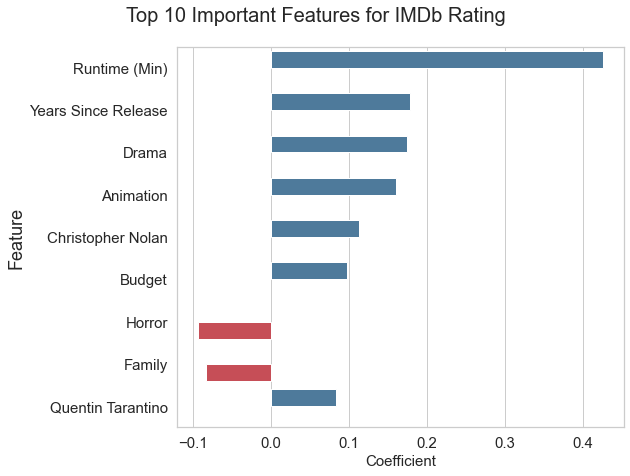

In [325]:
sns.set_theme(style="whitegrid")
cmap = sns.diverging_palette(240, 10, n=2)
movie_coef = sns.barplot(
    y=plot_name,
    x=plot_coef,
    hue=colors,
    palette=cmap,
    orient='h',
    )
movie_coef.set_title('Top 10 Important Features for IMDb Rating',fontsize=20,y=1.05, x=0.31)
movie_coef.get_legend().set_visible(False)
movie_coef.set_xlabel('Coefficient',fontsize=15)
movie_coef.set_ylabel('Feature',fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
fig = movie_coef.get_figure()
fig.savefig('top_features.png', bbox_inches='tight')
# plt.savefig('coefficients.png')

Since our data is scaled for our Ridge regression, we can just look at the coefficients for importance. It seems that runtime and years since release are two important factors in rating. Also, Drama and Animation are good genres to enter with Christopher Nolan and Quentin Tarantino being two directors who have a high influence over movie rating. As for negative impact, it seems that Horror and Family are two genres that will not help improve the rating of the movie.

In [ ]:
plt.scatter(model_pred, y_test, alpha=.5)
plt.plot(np.linspace(0,10), np.linspace(0,10))
plt.title('Final Model Prediction vs. Target')
plt.xlabel('Predicted IMDb Rating')
plt.ylabel('Actual IMDb Rating')
plt.axis([3,10,2,10]);

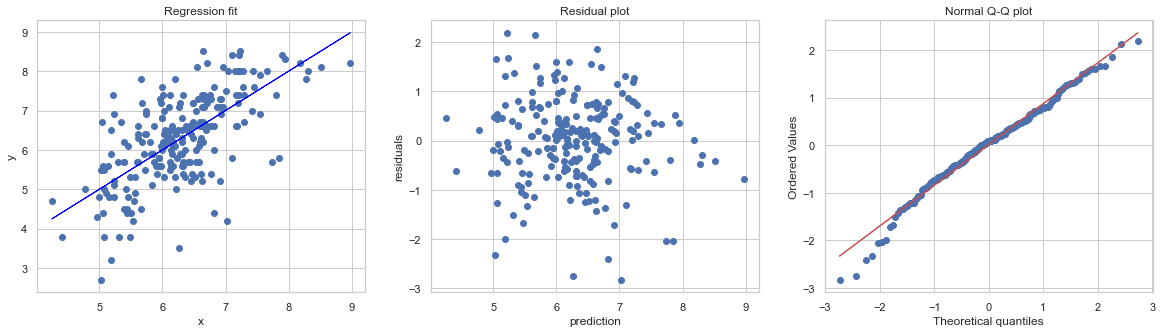

In [369]:
diagnostic_plot(model_pred, y_test)

## Extras: My exploration into leakage

I thought it was a good idea to include the director's mean IMDb average, but quickly learned the defintion of leakage. Let's take a look at what happened.

In [235]:
leakage_model = month_model.copy()
# Let's create a new model to highlight the leakage error I explored in my project.

In [230]:
df_dir_exploded.groupby('director').mean()['imdb rating'].sort_values(ascending=False)[:-100:-1]
print('Min: {}'.format(df_dir_exploded.groupby('director').mean()['imdb rating'].sort_values(ascending=False).min()))
print('Max: {}'.format(df_dir_exploded.groupby('director').mean()['imdb rating'].sort_values(ascending=False).max()))

# Look at each director's mean rating

Min: 1.3
Max: 9.4


Now I must figure out how to use these mean ratings to organize the directors and include it in the model

In [231]:
mean_dir_rating = pd.DataFrame(df_dir_exploded.groupby('director').mean()['imdb rating'].sort_values(ascending=False))
# Group the directors and sort by the mean of their ratings

In [234]:
def dir_rating_column(dir_list):
    for director in dir_list:
        rating = 0
        if mean_dir_rating.loc[director]["imdb rating"] > rating:
            rating = mean_dir_rating.loc[director]["imdb rating"]
        return rating
# Create a function to make this new column
# I decided to just use the mean rating rather than bins

In [236]:
leakage_model['mean director rating'] = movie_drop2['director'].apply(lambda x:dir_rating_column(x))
# Utilize that function

In [238]:
X, y = leakage_model.iloc[:,2:], leakage_model['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)
# Look at that score!

0.9196321391082555

I thought I had it all figured out, but after speaking with a TA and a teacher, it was obvious that mean target was leaking into my model, so I had to change this concept and that's when I redirected my concept of treating directors, writers, stars, and production companies.